# SERGAS data analysis

author: JAH, JJG

version: 15/06/20


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
import matplotlib.dates as mdates
print("Last updated on ", time.asctime())

Last updated on  Tue Jun 16 19:13:24 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

from scipy import stats

In [4]:
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
from c19.data_functions_HG import hg_get_data_ingresos, hg_get_data_pacientes, hg_get_data_age
from c19.HG_analysis import plot_hgi, plot_nh_nu, recovery_time, exitus_time, exitus_group, exitus, hosp_uci, select_age_by_CA_and_sex
from c19.HG_analysis import hist_XY_series, plot_XY_series, plot_pop_age
from c19.HG_analysis import formatter

In [6]:
datapath="/Users/hernando/investigacion/bio/c19/data/HospitalesGalicia"
file = "IngresosCovid.csv"
filep = "PacientesCOVID.csv"
ff =f'{datapath}/{file}'
fp =f'{datapath}/{filep}'
dfi = pd.read_csv(ff, sep='|')

## HGalicia

### ingresos

In [7]:
def get_cases(df, index = 'ingreso'):
    nps = df.groupby([index]).pacienteID.count()
    sel = nps.index >= np.datetime64('2020-02-15')
    dates, cases = nps.index[sel], nps.values[sel]
    return dates, cases

def get_deaths(dfp, code = 'EXITUS'):
    sel = (dfp.code == 'EXITUS') & (dfp.alta.values >= np.datetime64('2020-02-01'))
    dfe = dfp[sel] 
    nps = dfe.groupby(['alta']).pacienteID.count()
    dates, cases = nps.index, nps.values
    return dates, cases

def plot_cases(dates, cases, title = ''):
    plt.figure(figsize = (8, 6))
    plt.errorbar(dates, cases, yerr = np.maximum(np.sqrt(cases), 2.4), 
                 ls = '', marker = 'o', ms = 4)
    formatter(plt.gca());

In [8]:
hgi = hg_get_data_ingresos(ff)
hgi.head()

,pacienteID,ingreso,alta,hosp
0,8,2020-03-18,2020-03-26,HOS
1,9,2020-03-29,2020-04-24,HOS
2,10,2020-03-27,2020-04-07,HOS
3,10,2020-04-14,2020-04-30,HOS
4,12,2020-03-23,2020-04-09,HOS


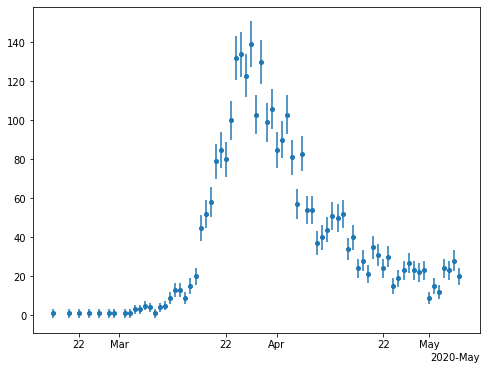

In [9]:
dates, cases = get_cases(hgi)
plot_cases(dates, cases, 'cases');

### decesos

In [10]:
dfp = hg_get_data_pacientes(fp)
dfp.head()

,pacienteID,ingreso,alta,edad,sexo,code
0,1,2020-03-25,2020-03-30,102,Mujer,EXITUS
1,2,2020-03-27,2020-03-31,101,Mujer,EXITUS
2,3,2020-03-27,2020-04-19,100,Mujer,EXITUS
3,4,2020-04-01,2020-04-24,99,Mujer,EXITUS
4,5,2020-03-28,2020-04-05,99,Mujer,EXITUS


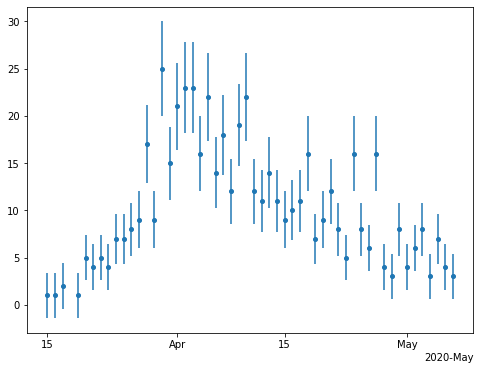

In [11]:
dates, cases = get_deaths(dfp)
plot_cases(dates, cases, 'exitus');

### Exitus time distribution

In [12]:
dfp = hg_get_data_pacientes(fp)
print(set(dfp.code))
print(dfp.head())

{'UCI', nan, 'HOS', 'EXITUS'}
   pacienteID    ingreso       alta  edad   sexo    code
0           1 2020-03-25 2020-03-30   102  Mujer  EXITUS
1           2 2020-03-27 2020-03-31   101  Mujer  EXITUS
2           3 2020-03-27 2020-04-19   100  Mujer  EXITUS
3           4 2020-04-01 2020-04-24    99  Mujer  EXITUS
4           5 2020-03-28 2020-04-05    99  Mujer  EXITUS


In [13]:
import c19.cfit as cfit

def fchi2(xs, ys):
    nscale = np.sum(ys)
    yerr   = np.maximum(np.sqrt(ys), 2.4)
    
    def _fun(pars):
        c, m = pars[0], pars[1]
        ds   = (nscale * stats.weibull_min(c, scale = m).pdf(xs) - ys)/yerr
        return ds * ds
    
    return _fun

In [14]:
sel = (dfp.code == 'EXITUS') & (dfp.alta.values >= np.datetime64('2020-02-01'))
dtime = (dfp[sel].alta.values - dfp[sel].ingreso.values)/ np.timedelta64(1, 'D')
print(np.mean(dtime), np.std(dtime), len(dtime))

tm     = np.mean(dtime)
nscale = len(dtime)

ndays  = int(np.max(dtime))

ys, xs = np.histogram(dtime, ndays, (0, ndays))
xs = 0.5 * (xs[1 :] + xs[:-1])

9.622920517560074 8.208587967754653 541


fit weibull  [ 1.23213583 11.18175588]
weibull mean  10.22569210720256 tm  9.622920517560074


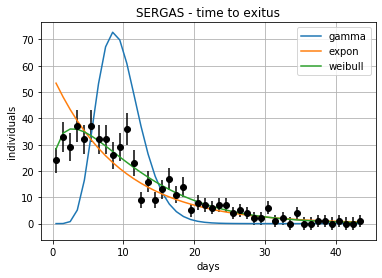

In [15]:
ffun = fchi2(xs, ys)
pars = np.array((1.5, tm))


res = cfit.minimize(pars, ffun)
print('fit weibull ', res)

ndays = 40
plt.errorbar(xs, ys, yerr = np.maximum(2.4, np.sqrt(ys)), ls = '', marker = 'o', c = 'black')

plt.plot(xs, nscale * stats.gamma(tm).pdf(xs), ls = '-', label = 'gamma')
plt.plot(xs, nscale * stats.expon(scale = tm).pdf(xs), ls = '-', label = 'expon')
plt.plot(xs, nscale * stats.weibull_min(res[0], scale = res[1]).pdf(xs), ls = '-', label = 'weibull')
plt.grid(); plt.xlabel('days'); plt.ylabel('individuals'); plt.title('SERGAS - time to exitus')
plt.legend();

nmean = np.sum(xs * stats.weibull_min(res[0], scale = res[1]).pdf(xs))
print('weibull mean ', nmean, 'tm ', tm)

weibull mean  10.22569210720256 tm  9.622920517560074


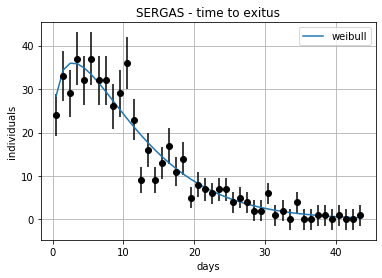

In [16]:
ndays = 40
plt.errorbar(xs, ys, yerr = np.maximum(2.4, np.sqrt(ys)), ls = '', marker = 'o', c = 'black')
plt.plot(xs, nscale * stats.weibull_min(res[0], scale = res[1]).pdf(xs), ls = '-', label = 'weibull')
plt.grid(); plt.xlabel('days'); plt.ylabel('individuals'); plt.title('SERGAS - time to exitus')
plt.legend();

nmean = np.sum(xs * stats.weibull_min(res[0], scale = res[1]).pdf(xs))
print('weibull mean ', nmean, 'tm ', tm)

## Cases vs time - Pandemic evolution

### KF - cases

#### Tr 2.8, Ti 5

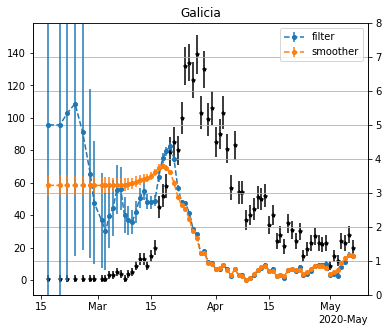

In [17]:
import c19.useir     as us
import c19.useir_ana as usa
blind = False
q0    = 2e-4

dates, cases = get_cases(hgi)
ucases = np.maximum(2.4, np.sqrt(cases))

dates_blind  = ('2020-03-25','2020-04-05') if blind is True else ('2020-07-25','2020-08-05')
times = (2.8, 5.0, 10.) # infecting time, incubation time, time to death

rs_smooth, rs_filter = us.useir_kfs_comomo(dates, cases, ucases, times, 
                                           dates_blind = dates_blind, q0 = q0)
usa.plot_data_kfs_rs(dates, cases, rs_filter, rs_smooth = rs_smooth, ucases = ucases)
plt.title('Galicia');

### KF - exitus

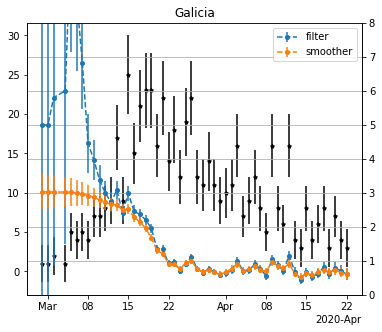

In [18]:
mdates, mcases = get_deaths(dfp)
umcases = np.maximum(2.4, np.sqrt(mcases))
blind = False
q0    = 1e-3
times = (2.7, 5., 10)

dates_blind  = ('2020-03-25','2020-04-05') if blind is True else ('2020-07-25','2020-08-05')
times = (2.8, 5.0, 10.) # infecting time, incubation time, time to death

xdates = np.timedelta64(15, 'D')


##TODO: two regions of q0

rs_smooth, rs_filter = us.useir_kfs_comomo(mdates, mcases, umcases, times, 
                                           dates_blind = dates_blind, q0 = q0)
usa.plot_data_kfs_rs(mdates - xdates, mcases, rs_filter, rs_smooth = rs_smooth, ucases = umcases)
plt.title('Galicia');

### Chi2 fit

In [19]:
nn = {'Madrid': 6578079, 'Castilla y Leon': 2409164, 'Castilla La Mancha': 2026807, 
      'Cataluna': 7600065, 'C. Valenciana': 4963703, 'Aragon': 1308728, 'Pais Vasco': 2199088, 
      'Navarra': 647554, 'La Rioja': 315675, 'Cantabria': 580229, 'Asturias': 1028244, 
      'Galicia': 2701743, 'Murcia': 1478509, 'Andalucia': 8384408, 'Extremadura': 1072863, 
      'Baleares': 1128908, 'Canarias': 2127685}

n0  = nn['Galicia']

### fit - code

In [20]:
TR, TI = 2.7, 5.

masks0 =  2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))
masks1 =  2 * (('t0', 'phi'), ('phi', 'beta', 'gamma'))
masks2 =  2 * (('t0',), ('beta', 'gamma')) 

def kpars0(tr = TR, ti = TI):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr / 20)}
    return kpars

def fit(dates, cases, masks = masks0, kpars = None, tr = TR, ti = TI, ffit = 'chi2'):
    kpars = kpars0(tr, ti) if kpars is None else kpars
    for imask in masks:
        kpars, fval = usa.useirqr_fit(dates, cases, kpars = kpars, kmask = imask, ffit = ffit)
    kpars[ffit] = fval
    return kpars

def fit_scan(dates, cases, masks = masks0, trs = (TR,), tis = (TI,), ffit = 'chi2'):
    dpars = []
    tbar = IntProgress(0, max = len(trs) * len(tis), description = 'fitting...'); 
    display(tbar); tbar.value = 1
    for ti in tis:
        for tr in trs:
            tbar.value += 1
            kpars = fit(dates, cases, masks, tr = tr, ti = ti, ffit = ffit)
            dpars.append(kpars.copy())                
    return dpars

def plot_fit(dates, cases, kpars):
    mpars = kpars.copy(); 
    if 'chi2' in mpars.keys(): mpars.pop('chi2')
    fmodel = usa.useirqr_fmodel(kpars = mpars)
    usa.plot_data_model(dates, cases, fmodel)
    return

def plot_fit_scan(dates, cases, dpars):
    ncols, nrows = 2, max(int(len(dpars)/2), 1)
    if (len(dpars) % nrows != 0): nrows += 1
    plt.figure(figsize = (6 * ncols, 5 * nrows))
    for i, dpar in enumerate(dpars):
        ax = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
        plot_fit(dates, cases, dpar)        
    plt.tight_layout()
    return

def to_df(dpars):
    nsize = len(dpars)
    keys = dpars[0].keys()
    dat = {}
    for key in keys:
        dat[key] = np.array([dpar[key] for dpar in dpars])
    df = pd.DataFrame(dat)
    return df


### cases initial seed

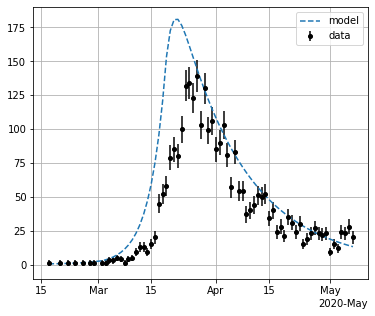

In [21]:
plot_fit(dates, cases, kpars0())

#### Free fit

{'t0': 17.478338467420258, 'beta': 1.4813611683500412, 'gamma': 0.22274236290139598, 'tr': 2.7, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06794475121769988, 's1': 0.0070894989892696485, 'chi2': 141.48659581087549}
R0  3.9996751545451112 R1 0.6014043798337692
Phi  6.794475121769988  S1 0.7089498989269648


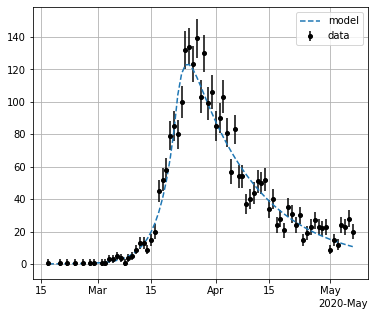

In [22]:
kpars = fit(dates, cases)
plot_fit(dates, cases, kpars)
print(kpars)
R0, R1 = kpars['beta'] * 2.7, 2.7 * kpars['gamma']
print('R0 ', R0, 'R1', R1)
print('Phi ', 100. * kpars['phi'], ' S1', 100 * kpars['s1'])

#### Constrained fit: S1 from fit to deaths

{'t0': 21.452184562257216, 'beta': 1.4831157284719145, 'gamma': 0.2274548050522792, 'tr': 2.7, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.026178500899594115, 's1': 0.015, 'chi2': 142.0188780715458}
R0  4.00441246687417 R1 0.6141279736411539
Phi  2.6178500899594113  S1 1.5


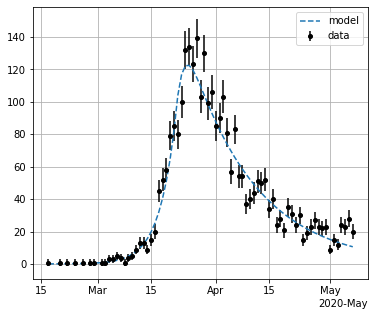

In [23]:
# mask1 - fix S1
kpars_ = kpars.copy(); kpars_.pop('chi2'); kpars_['s1'] = 0.015
kpars1 = fit(dates, cases, kpars = kpars_, masks = masks1)
plot_fit(dates, cases, kpars1)
print(kpars1)
R0, R1 = kpars1['beta'] * 2.7, 2.7 * kpars1['gamma']
print('R0 ', R0, 'R1', R1)
print('Phi ', 100. * kpars1['phi'], ' S1', 100 * kpars1['s1'])

#### Constrained fit: S1 and phi from fit to deaths

{'t0': 21.452184562257216, 'beta': 1.4063281481696, 'gamma': 0.21617241616035102, 'tr': 2.7, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.035, 's1': 0.015, 'chi2': 145.16319452354787}
R0  3.79708600005792 R1 0.5836655236329478
Phi  3.5000000000000004  S1 1.5


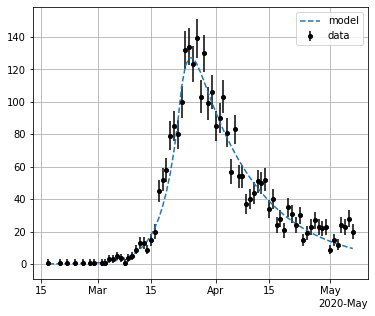

In [24]:
kpars_ = kpars1.copy(); kpars_.pop('chi2'); kpars_['phi'] = 0.035; kpars_['s1'] = 0.015
kpars2 = fit(dates, cases, kpars = kpars_, masks = masks2)
plot_fit(dates, cases, kpars2)
print(kpars2)
R0, R1 = kpars2['beta'] * 2.7, 2.7 * kpars2['gamma']
print('R0 ', R0, 'R1', R1)
print('Phi ', 100. * kpars2['phi'], ' S1', 100 * kpars2['s1'])

### death fit

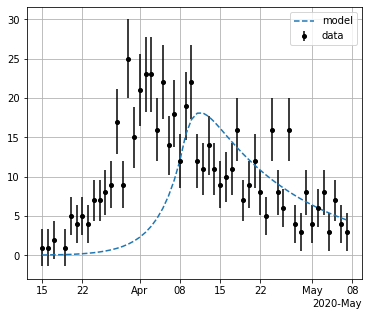

In [25]:
kmpars = kpars0()
kmpars['phi'] = 0.01
plot_fit(mdates, mcases, kmpars)

In [26]:
def qmfit(dates, cases, ucases, kpars = None, masks = None, fit = False):

    ts                   = np.arange(len(dates))

    def kpars0(tr = TR, r0 = 4., r1 = 0.8):
        n0  = nn['Galicia']
        phi = 0.01
        s1  = 0.6 * np.sum(cases)/(n0 * phi)
    
        kpars =  {'t0': 40.0, 'beta': r0/tr, 'gamma': r1/tr, 'tr': tr, 'ti': TI, 
                   'tm': 9., 'n': n0, 'phi': phi, 's1': s1}
        return kpars
    
    kpars = kpars0() if kpars is None else kpars 
    masks = masks0   if masks is None else masks
    chi2 = 0.
    if (fit):
        #tbar = IntProgress(0, max = len(masks), description = caname); display(tbar)
        for imask in masks:
            #tbar.value += 1
            kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
            #print(caname, 'chi2 : ', chi2, ', kpars: ', kpars, ', mask ', imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    plt.title('exitus - Galicia')
    return kpars, chi2

#### free fit

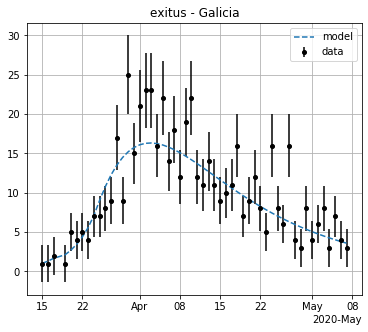

In [27]:
kmpars, chi2 = qmfit(mdates, mcases, umcases, fit = True)

In [28]:
print(kmpars)
R0, R1 = kmpars['beta'] * 2.7, 2.7 * kmpars['gamma']
print('R0 ', R0, 'R1', R1)
print('Phi ', 100. * kmpars['phi'], ' S1', 100 * kmpars['s1'])

{'t0': 38.4102747327925, 'beta': 1.519279038710432, 'gamma': 0.2249008115960487, 'tr': 2.7, 'ti': 5.0, 'tm': 9.0, 'n': 2701743.0, 'phi': 0.004768436504999958, 's1': 0.01525238818555663}
R0  4.102053404518167 R1 0.6072321913093315
Phi  0.4768436504999958  S1 1.525238818555663


#### Constrained fit: S1 

{'t0': 37.79527882415326, 'beta': 1.4806669100636713, 'gamma': 0.20862823676067246, 'tr': 2.7, 'ti': 5.0, 'tm': 9.0, 'n': 2701743.0, 'phi': 0.0063413820455810906, 's1': 0.01525238818555663}
R0  3.9978006571719127 R1 0.5632962392538157
Phi  0.6341382045581091  S1 1.525238818555663


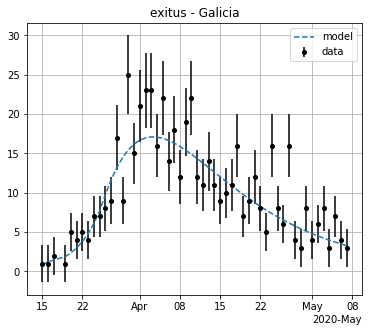

In [29]:
kmpars_ = kmpars.copy(); 
kmpars1, chi2 = qmfit(mdates, mcases, umcases, kpars = kmpars_, 
                     masks = masks1, fit = True)
print(kmpars1)
R0, R1 = kmpars1['beta'] * 2.7, 2.7 * kmpars1['gamma']
print('R0 ', R0, 'R1', R1)
print('Phi ', 100. * kmpars1['phi'], ' S1', 100 * kmpars1['s1'])

#### x-checks

In [30]:
phi, phim = kpars2['phi'], kmpars1['phi']
print('n0 :', np.sum(mcases)/phim, np.sum(cases)/phi)

n0 : 85312.6331312886 85971.42857142857


### Conclusions

- The exitus distribution is a Weibull with mean 9.6 days, and parameter 1.23

- cases per day follows the uSEIR-quenched distribution, assuming Tr = 2.7 and Ti = 5 (from scan on tis, trs, see times_scan note-book), with R0 in 4 and R1 0.6

- deaths per day follows the uSEIR-quenched ditributions, Tr = 27, Ti = 5, Tm = 10,

- constraining S1 and phi parameters using the data from the death fit, boths fits are compatible, the results are:

In [31]:
print(kpars2)

{'t0': 21.452184562257216, 'beta': 1.4063281481696, 'gamma': 0.21617241616035102, 'tr': 2.7, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.035, 's1': 0.015, 'chi2': 145.16319452354787}


In [32]:
print(kmpars1)

{'t0': 37.79527882415326, 'beta': 1.4806669100636713, 'gamma': 0.20862823676067246, 'tr': 2.7, 'ti': 5.0, 'tm': 9.0, 'n': 2701743.0, 'phi': 0.0063413820455810906, 's1': 0.01525238818555663}
